In [1]:
import pandas as pd

df = pd.read_csv('./data/train_df.csv', index_col=0)
train_data = df.loc[(df.time < '2018-01-01')]
backtest_data = df.loc[(df.time >= '2018-02-01')]

etf_list = train_data.code.drop_duplicates().sort_values().values
df.head(10)
etf_list

array(['159905.XSHE', '159915.XSHE', '159928.XSHE', '159929.XSHE',
       '159934.XSHE', '510050.XSHG', '510300.XSHG', '510500.XSHG'],
      dtype=object)

In [9]:
import talib 
from functools import reduce


def cross_over(x, y, data):
    data[f'RSI_{x} - RSI_{y}'] = data[f'RSI_{x}'] - data[f'RSI_{y}'] 
    data[f'MA_{x} - MA_{y}'] = data[f'MA_{x}'] - data[f'MA_{y}'] 
    data[f'SMA_{x} - SMA_{y}'] = data[f'SMA_{x}'] - data[f'SMA_{y}'] 
    data[f'AROONOSC_{x} - AROONOSC_{y}'] = data[f'AROONOSC_{x}'] - data[f'AROONOSC_{y}']
    return y

def compute_rank_daily(data):
    data['target'] = data.groupby("time")['pct_change'].rank()
    return data

def get_target_level(target, data):
    if target > data.quantile(.7):
        return 2
    if target > data.mean():
        return 1
    if target < data.mean():
        return 0
    if target < data.quantile(.3):
        return -1



def get_features(data):
    tech_data = pd.DataFrame(index=data.index);
    days = range(2, 10)
    for t in days:
        tech_data[f'BETA_{t}'] = talib.BETA(data.high, data.low, timeperiod=t)
        tech_data[f'SMA_{t}'] = talib.SMA(data.close,timeperiod=t)
        tech_data[f'RSI_{t}'] = talib.RSI(data.close, timeperiod=t)
        tech_data[f'MOM_{t}'] = talib.MOM(data.close, timeperiod=t)
        tech_data[f'MA_{t}'] = talib.MA(data.close, timeperiod=t)
        tech_data[f'CCI_{t}'] = talib.CCI(data.high, data.low, data.close, timeperiod=t)
        tech_data[f'DX_{t}'] = talib.DX(data.high, data.low, data.close, timeperiod=t)
        tech_data[f'volatility_{t}'] = data.close.pct_change(periods=t).std()
        tech_data[f'ADX_{t}'] = talib.ADX(data.high, data.low, data.close, timeperiod=t)
        tech_data[f'ADXR_{t}'] = talib.ADXR(data.high, data.low, data.close, timeperiod=t)
        tech_data[f'AROONOSC_{t}'] = talib.AROONOSC(data.high, data.low, timeperiod=t)
        tech_data[f'ROC_{t}'] = talib.ROC(data.close, timeperiod=t)
        tech_data[f'BIAS_{t}'] = (data['close'] - data['close'].rolling(t, min_periods=1).mean())/ data['close'].rolling(t, min_periods=1).mean()*100
        tech_data[f'BOLL_upper_{t}'], tech_data[f'BOLL_middle_{t}'], tech_data[f'BOLL_lower_{t}'] = talib.BBANDS(
                data.close,
                timeperiod=t,
                nbdevup=2,
                nbdevdn=2,
                matype=0)

    tech_data['SAR'] = talib.SAR(data.high, data.low)
    tech_data['AD'] = talib.AD(data.high, data.low, data.close, data.volume)
    tech_data['OBV'] = talib.OBV(data.close, data.volume)
    tech_data['MACD'], tech_data['MACDSIGNAL'], tech_data['MACDHIST'] = talib.MACD(data.close, fastperiod=12, slowperiod=26, signalperiod=9)
    
    tech_data['code'] = data.code
    tech_data['pct_change'] = data.close.pct_change().shift(-1)
    tech_data['target'] = tech_data['pct_change'].apply(lambda x: get_target_level(x, tech_data['pct_change']))
    tech_data['time'] = data.time
        
#     reduce(lambda x,y: cross_over(x, y, tech_data), days)
    
    features = list(set(tech_data.columns) - set(data.columns) - set(['target', 'pct_change'])) 
    return tech_data.dropna(), features



data_sets = pd.DataFrame()
features = []
for i in etf_list:
    etf_data, etf_features = get_features(train_data[train_data.code == i])
    data_sets = pd.concat([data_sets, etf_data])
    features = etf_features
    


## 对最后的数据集做处理
data_sets = data_sets.dropna()
data_sets = data_sets.set_index('code')
data_sets = data_sets.sort_values('time')
data_sets.tail(8)

,BETA_2,SMA_2,RSI_2,MOM_2,MA_2,CCI_2,DX_2,volatility_2,ADX_2,ADXR_2,...,BOLL_lower_9,SAR,AD,OBV,MACD,MACDSIGNAL,MACDHIST,pct_change,target,time
code,,,,,,,,,,,,,,,,,,,,,
159929.XSHE,0.338515,1.5830,53.311319,-0.002,1.5830,66.666667,79.286468,0.027053,67.533456,61.656950,...,1.573314,1.560932,3.243950e+08,3.319110e+08,0.002920,0.002261,0.000659,0.001889,1.0,2017-12-28
510050.XSHG,-2.188196,3.5810,45.753248,-0.048,3.5810,0.000000,72.262445,0.023653,77.539367,80.177828,...,3.553620,3.559000,3.285841e+10,3.053451e+10,0.001324,0.004823,-0.003499,0.001113,1.0,2017-12-28
159934.XSHE,0.626108,2.7085,95.649715,0.010,2.7085,66.666667,98.982882,0.011525,93.455700,90.692109,...,2.669363,2.663822,-1.767230e+08,4.157718e+08,-0.003543,-0.009216,0.005673,-0.000368,0.0,2017-12-28
159928.XSHE,-1.791506,2.3400,50.859173,-0.043,2.3400,-66.666667,70.494676,0.025724,74.583764,76.628308,...,2.285013,2.299101,1.411383e+08,1.908630e+08,0.042046,0.035082,0.006964,-0.009766,0.0,2017-12-28
159915.XSHE,-6.058284,1.6335,43.185228,-0.007,1.6335,66.666667,97.412793,0.035454,95.009275,93.807516,...,1.622096,1.685448,2.685512e+10,1.308263e+10,-0.020245,-0.019268,-0.000978,0.004276,1.0,2017-12-28
159905.XSHE,0.671894,1.7225,58.659665,-0.007,1.7225,66.666667,68.327282,0.027732,60.888955,57.169792,...,1.692084,1.769000,7.962869e+08,1.190363e+09,0.012911,0.010542,0.002368,0.001153,1.0,2017-12-28
510300.XSHG,-3.021633,4.3740,52.487223,-0.034,4.3740,66.666667,87.978065,0.024943,78.704075,74.067081,...,4.340549,4.470540,4.709556e+10,3.480966e+10,-0.007499,-0.005508,-0.001992,0.003186,1.0,2017-12-28
510500.XSHG,0.000185,1.8235,53.509761,-0.008,1.8235,66.666667,91.040388,0.030692,87.798824,86.178042,...,1.816784,1.860120,1.073570e+10,6.565597e+09,-0.014016,-0.015760,0.001744,0.010394,2.0,2017-12-28


In [10]:
print('Features:')
display(features)

Features:


['CCI_3',
 'BETA_9',
 'BETA_5',
 'ADXR_8',
 'BOLL_upper_2',
 'MA_4',
 'BOLL_lower_5',
 'BOLL_upper_6',
 'BIAS_2',
 'RSI_2',
 'BOLL_lower_4',
 'RSI_5',
 'ROC_5',
 'MA_7',
 'BIAS_8',
 'OBV',
 'ADX_6',
 'ADX_8',
 'MACD',
 'BIAS_6',
 'CCI_2',
 'DX_8',
 'AROONOSC_9',
 'ROC_3',
 'BIAS_9',
 'DX_6',
 'DX_4',
 'BOLL_middle_7',
 'BIAS_3',
 'BOLL_upper_4',
 'BOLL_lower_8',
 'MOM_7',
 'SMA_2',
 'BOLL_upper_7',
 'ADX_7',
 'DX_7',
 'AROONOSC_8',
 'DX_5',
 'BOLL_lower_9',
 'volatility_4',
 'SMA_6',
 'BETA_7',
 'volatility_5',
 'BOLL_upper_9',
 'BOLL_middle_4',
 'ADX_2',
 'ADXR_3',
 'BOLL_lower_6',
 'MOM_8',
 'BETA_3',
 'DX_9',
 'BIAS_5',
 'CCI_9',
 'ROC_8',
 'DX_2',
 'MA_5',
 'BIAS_7',
 'AROONOSC_3',
 'MOM_9',
 'RSI_7',
 'ADX_9',
 'BOLL_middle_3',
 'BETA_4',
 'volatility_3',
 'AROONOSC_4',
 'MA_6',
 'MACDSIGNAL',
 'BOLL_middle_9',
 'MA_2',
 'BOLL_lower_7',
 'ROC_2',
 'RSI_3',
 'ADXR_4',
 'BOLL_middle_8',
 'SMA_8',
 'ROC_9',
 'CCI_7',
 'BIAS_4',
 'AROONOSC_7',
 'MOM_5',
 'DX_3',
 'AROONOSC_2',
 'SMA_3

In [11]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, LassoCV
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import classification_report



def save_model(model, filename):
    import pickle
    from six import BytesIO
    pkl_file = open(filename, 'wb')
    pickle.dump(model, pkl_file, 0)
    pkl_file.close()


date = data_sets.index.drop_duplicates()

# data_sets = data_sets.loc[data_sets.index.isin(date[::2])]

## propressing

data_sets.tail(10)

,BETA_2,SMA_2,RSI_2,MOM_2,MA_2,CCI_2,DX_2,volatility_2,ADX_2,ADXR_2,...,BOLL_lower_9,SAR,AD,OBV,MACD,MACDSIGNAL,MACDHIST,pct_change,target,time
code,,,,,,,,,,,,,,,,,,,,,
159905.XSHE,0.383282,1.7260,10.675827,-0.039,1.7260,-66.666667,54.115357,0.027732,53.450628,53.118264,...,1.675367,1.696592,7.944336e+08,1.183948e+09,0.012717,0.009950,0.002767,0.013442,2.0,2017-12-27
510300.XSHG,-1.435458,4.3910,11.650270,-0.061,4.3910,-66.666667,87.582456,0.024943,69.430086,60.353902,...,4.328123,4.473000,4.701030e+10,3.463033e+10,-0.006963,-0.005010,-0.001953,0.009187,2.0,2017-12-27
159929.XSHE,0.338515,1.5830,53.311319,-0.002,1.5830,66.666667,79.286468,0.027053,67.533456,61.656950,...,1.573314,1.560932,3.243950e+08,3.319110e+08,0.002920,0.002261,0.000659,0.001889,1.0,2017-12-28
510050.XSHG,-2.188196,3.5810,45.753248,-0.048,3.5810,0.000000,72.262445,0.023653,77.539367,80.177828,...,3.553620,3.559000,3.285841e+10,3.053451e+10,0.001324,0.004823,-0.003499,0.001113,1.0,2017-12-28
159934.XSHE,0.626108,2.7085,95.649715,0.010,2.7085,66.666667,98.982882,0.011525,93.455700,90.692109,...,2.669363,2.663822,-1.767230e+08,4.157718e+08,-0.003543,-0.009216,0.005673,-0.000368,0.0,2017-12-28
159928.XSHE,-1.791506,2.3400,50.859173,-0.043,2.3400,-66.666667,70.494676,0.025724,74.583764,76.628308,...,2.285013,2.299101,1.411383e+08,1.908630e+08,0.042046,0.035082,0.006964,-0.009766,0.0,2017-12-28
159915.XSHE,-6.058284,1.6335,43.185228,-0.007,1.6335,66.666667,97.412793,0.035454,95.009275,93.807516,...,1.622096,1.685448,2.685512e+10,1.308263e+10,-0.020245,-0.019268,-0.000978,0.004276,1.0,2017-12-28
159905.XSHE,0.671894,1.7225,58.659665,-0.007,1.7225,66.666667,68.327282,0.027732,60.888955,57.169792,...,1.692084,1.769000,7.962869e+08,1.190363e+09,0.012911,0.010542,0.002368,0.001153,1.0,2017-12-28
510300.XSHG,-3.021633,4.3740,52.487223,-0.034,4.3740,66.666667,87.978065,0.024943,78.704075,74.067081,...,4.340549,4.470540,4.709556e+10,3.480966e+10,-0.007499,-0.005508,-0.001992,0.003186,1.0,2017-12-28


### Feature Selection

In [12]:
X = data_sets[features]
y = data_sets['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# rest_len = len(X) % len(etf_list)
# X_train, X_test = np.split(X, [int(.67 *len(X)) - rest_len])
# y_train, y_test = np.split(y, [int(.67 *len(y)) - rest_len])

svm_parameters = {
    'regressor__n_estimators': (120, 130, 140, 150),
#     'regressor__max_depth': (2, 3, 4)
}

pipline = Pipeline([
    ('scale', MinMaxScaler()),
    ('feature_selection', SelectKBest(chi2)),
    ('feature process',PCA()),
    ('regressor', AdaBoostClassifier(random_state=44))
])

svm = GridSearchCV(pipline, svm_parameters, cv=3, n_jobs=4)


svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print('参数:', svm.best_params_)
print('R方值:', accuracy_score(y_test, svm_pred))

参数: {'regressor__n_estimators': 140}
R方值: 0.5076305220883535


In [13]:
svm.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('feature_selection',
                                        SelectKBest(score_func=<function chi2 at 0x7fb77a58f3b0>)),
                                       ('feature process', PCA()),
                                       ('regressor',
                                        AdaBoostClassifier(random_state=44))]),
             n_jobs=4,
             param_grid={'regressor__n_estimators': (120, 130, 140, 150)})

In [14]:
import datetime
import backtrader as bt
import backtrader.feeds as btfeed


class MLStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        self.position_list = []
        

    def next(self):
        today = self.datas[0].datetime.date(0).isoformat()
        signal_list = pd.DataFrame()   
        today_df = df[(df.time < today)] 

        
        for index, e in enumerate(etf_list):
            etf_data, etf_features = get_features(today_df[today_df.code == e])
            etf_data = etf_data.dropna()
            signal = svm.predict(etf_data[etf_features])

            today_signal = signal[-1]
            
            if (today_signal > 0): 
                signal_list.loc[index, 'increase'] = today_signal
            
        if len(signal_list):
            buy_list = signal_list.sort_values('increase').tail(3).index
            sell_list = set(self.position_list) - set(buy_list) 
            self.position_list = list(buy_list)
            
            self.log('buy_list: %s' % buy_list)
            self.log('sell_list: %s' % sell_list)
            
            for sell_index in sell_list:
                self.close(self.datas[sell_index])
            
            for buy_index in self.position_list:
                self.order_target_percent(data=self.datas[buy_index], target=1.00 / len(buy_list))
                

#         if len(self) % 30 == 0:
#             pred_data, _ = get_features(df.loc[df.time < today])
#             pred_data = pred_data.dropna()
#             pred_data = pred_data.set_index('code')
#             pred_data = pred_data.sort_values('time')
#             pred_data_y = pred_data['target']
#             pred_data_x = pred_data[features]
#             svm.fit(pred_data_x, pred_data_y)
#             print('fit model again')


Starting Portfolio Value: 100000.00
2018-02-01, buy_list: Int64Index([2], dtype='int64')
2018-02-01, sell_list: set()
2018-02-07, buy_list: Int64Index([0, 2], dtype='int64')
2018-02-07, sell_list: set()
2018-02-08, buy_list: Int64Index([0, 7], dtype='int64')
2018-02-08, sell_list: {2}
2018-02-09, buy_list: Int64Index([0, 6], dtype='int64')
2018-02-09, sell_list: {7}
2018-02-12, buy_list: Int64Index([0, 6], dtype='int64')
2018-02-12, sell_list: set()
2018-02-13, buy_list: Int64Index([6, 7], dtype='int64')
2018-02-13, sell_list: {0}
2018-03-01, buy_list: Int64Index([2], dtype='int64')
2018-03-01, sell_list: {6, 7}
2018-03-06, buy_list: Int64Index([7], dtype='int64')
2018-03-06, sell_list: {2}
2018-03-19, buy_list: Int64Index([4], dtype='int64')
2018-03-19, sell_list: {7}
2018-03-26, buy_list: Int64Index([0, 4, 5], dtype='int64')
2018-03-26, sell_list: set()
2018-04-11, buy_list: Int64Index([7], dtype='int64')
2018-04-11, sell_list: {0, 4, 5}
2018-04-12, buy_list: Int64Index([4], dtype='i

2019-08-15, buy_list: Int64Index([3], dtype='int64')
2019-08-15, sell_list: {0}
2019-09-04, buy_list: Int64Index([4], dtype='int64')
2019-09-04, sell_list: {3}
2019-10-15, buy_list: Int64Index([4], dtype='int64')
2019-10-15, sell_list: set()
2019-10-21, buy_list: Int64Index([7], dtype='int64')
2019-10-21, sell_list: {4}
2019-10-22, buy_list: Int64Index([7], dtype='int64')
2019-10-22, sell_list: set()
2019-10-28, buy_list: Int64Index([7], dtype='int64')
2019-10-28, sell_list: set()
2019-10-31, buy_list: Int64Index([4], dtype='int64')
2019-10-31, sell_list: {7}
2019-11-26, buy_list: Int64Index([2, 4, 7], dtype='int64')
2019-11-26, sell_list: set()
2019-11-28, buy_list: Int64Index([4], dtype='int64')
2019-11-28, sell_list: {2, 7}
2019-12-10, buy_list: Int64Index([4], dtype='int64')
2019-12-10, sell_list: set()
2019-12-11, buy_list: Int64Index([4], dtype='int64')
2019-12-11, sell_list: set()
2019-12-12, buy_list: Int64Index([2], dtype='int64')
2019-12-12, sell_list: {4}
2019-12-13, buy_lis

<IPython.core.display.Javascript object>


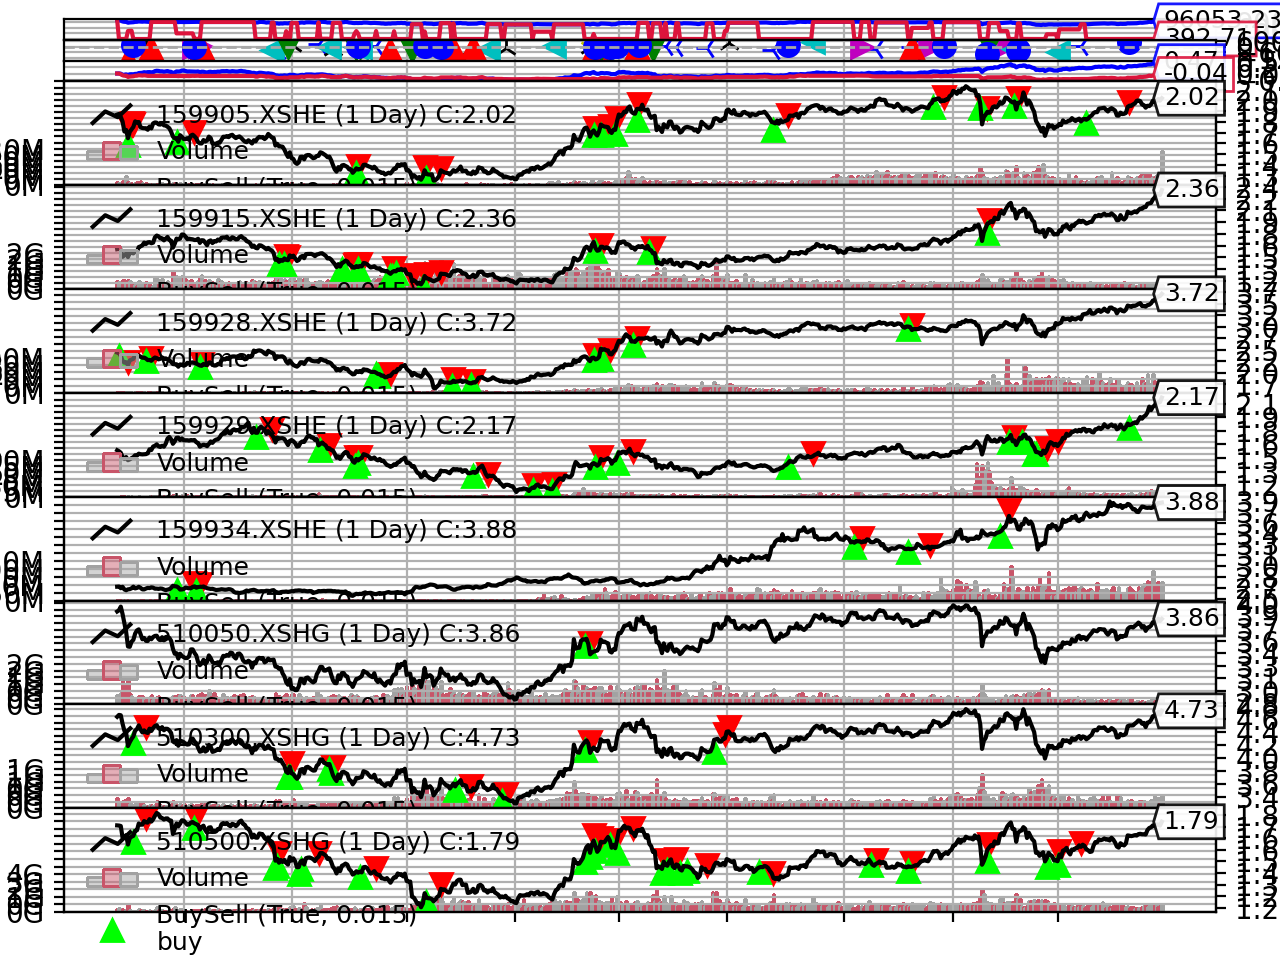

[[<Figure size 640x480 with 19 Axes>]]

In [16]:
# Create a cerebro entity
cerebro = bt.Cerebro()
backtest_data = df.loc[(df.time >= '2018-02-01') & (df.time < '2020-07-01')]

for etf in etf_list:
    etf_data = backtest_data[backtest_data.code == etf]
    etf_data = etf_data[['time', 'open', 'high', 'low', 'close', 'volume']]
    etf_data = etf_data.set_index('time')
    etf_data.index = pd.to_datetime(etf_data.index)
    etf_data = bt.feeds.PandasData(dataname=etf_data)
    cerebro.adddata(etf_data, etf)
    if etf == '159915.XSHE':
        benchdata = etf_data

        
# Add a strategy
cerebro.addstrategy(MLStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addobserver(bt.observers.Benchmark,
                            data=benchdata,
                            timeframe=bt.TimeFrame.NoTimeFrame)
cerebro.broker.setcash(100000.0)
 

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
%matplotlib notebook

cerebro.plot()

### Backtesting Analyzers

In [12]:
import pyfolio as pf

pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

# pf.create_full_tear_sheet(
#     returns=returns,
#     positions=positions,
#     transactions=transactions,
#     live_start_date='2019-02-01',
# )
positions


ModuleNotFoundError: No module named 'pyfolio'

In [195]:
rdf_parameters = {
    'classification__n_estimators':(140, 150, 160, 170, 180), 
    'classification__max_depth':[4, 5, 6, 7]
}

pipline = Pipeline([    
    ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))),
    ('classification', RandomForestClassifier())
])

rdf = GridSearchCV(pipline, rdf_parameters, cv=5)


rdf.fit(X_train, y_train)
rdf_pred = rdf.predict(X_test)
print('参数:', rdf.best_params_)
print('准确率:', accuracy_score(y_test, rdf_pred))
print('分类报告:', classification_report(y_test, rdf_pred))

NameError: name 'RandomForestClassifier' is not defined

<IPython.core.display.Javascript object>


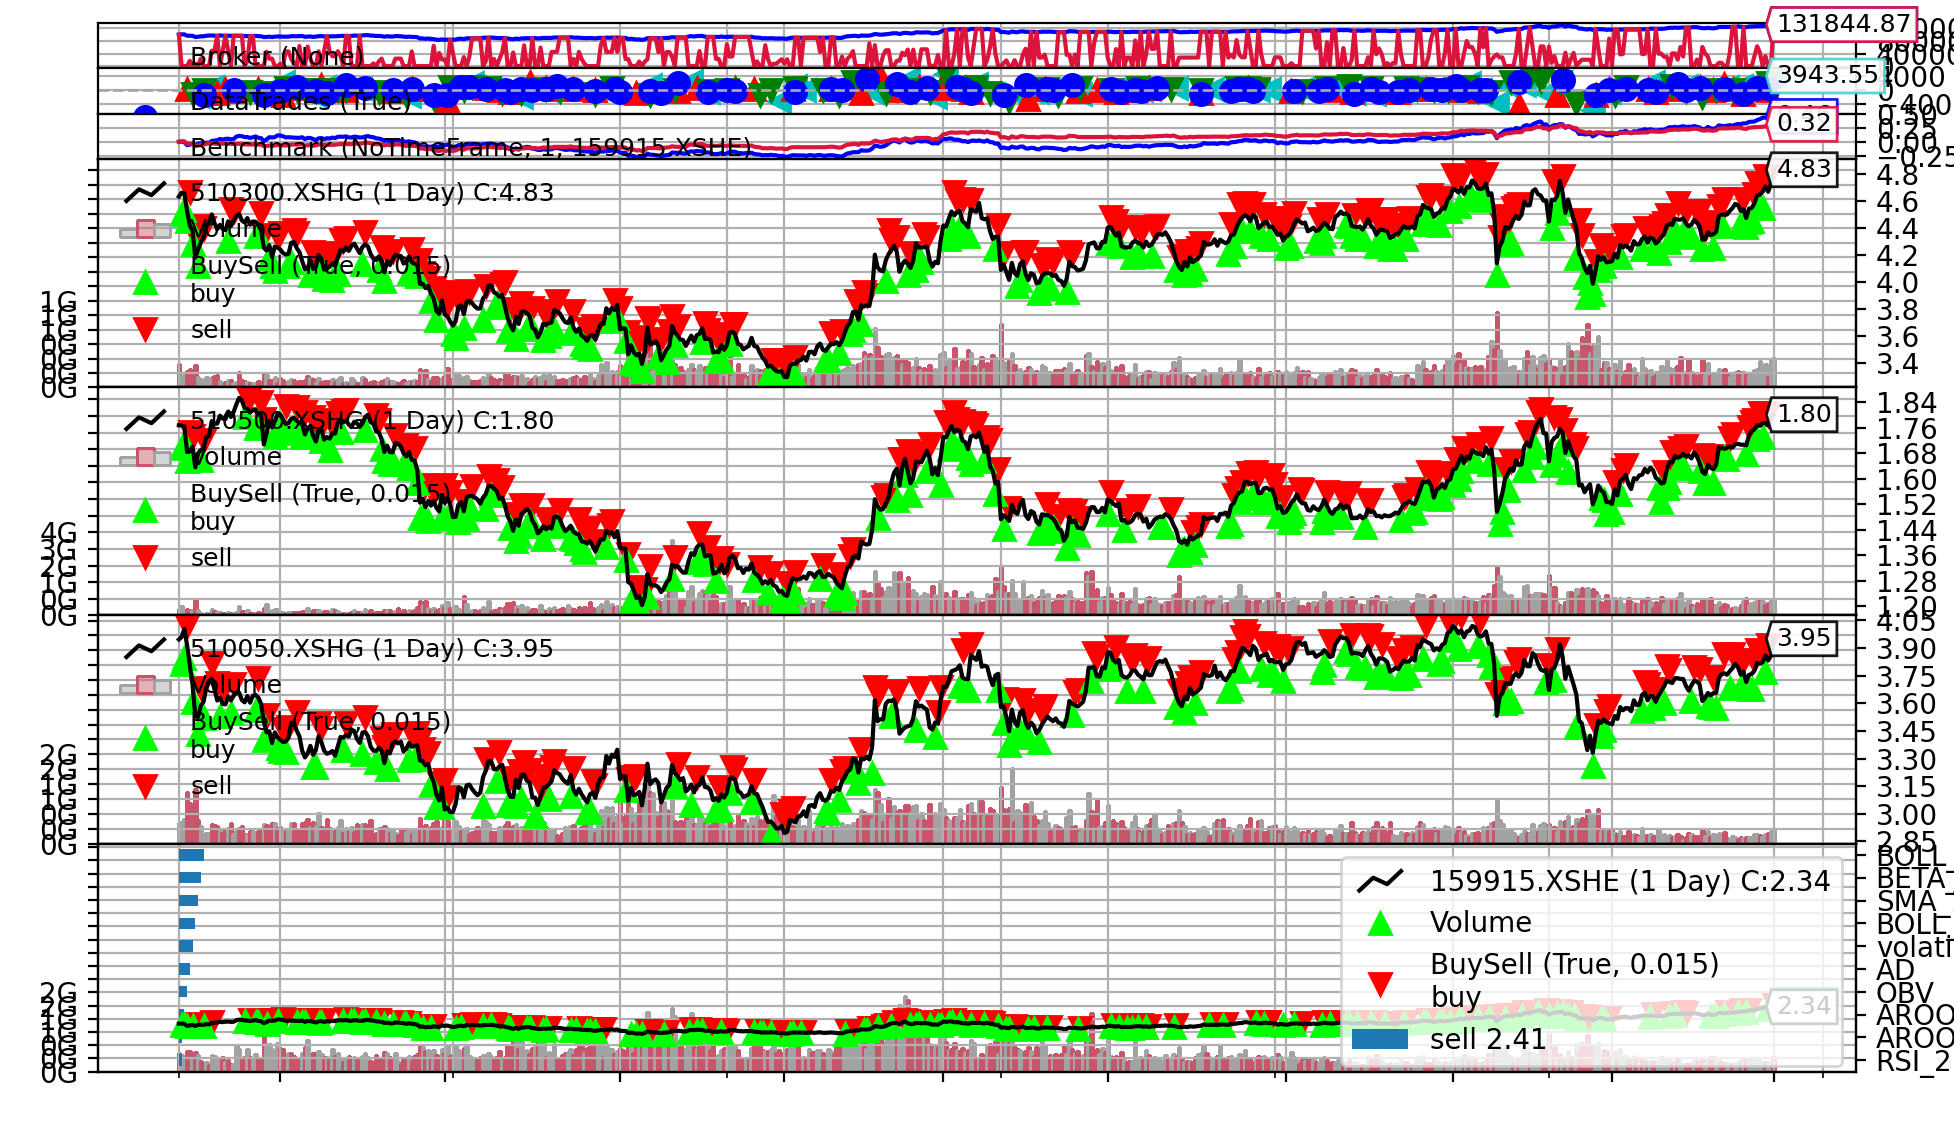

[[<Figure size 640x480 with 11 Axes>]]

In [74]:
%matplotlib notebook
cerebro.plot()

<IPython.core.display.Javascript object>


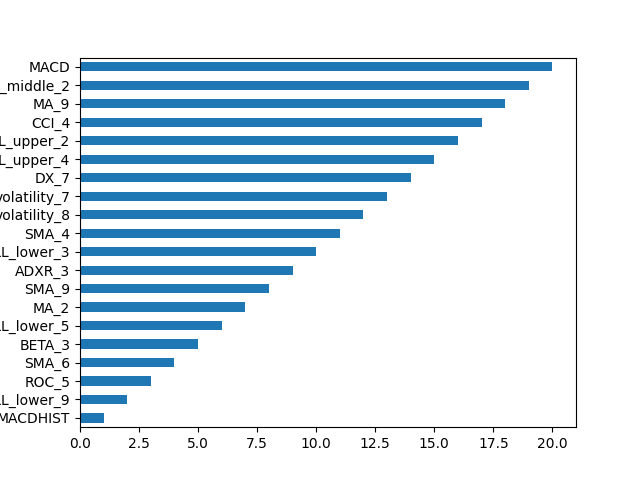

array([[-0.75503767],
       [-0.37787018],
       [-0.47292227],
       ...,
       [-0.23537507],
       [-0.22822162],
       [-0.27094771]])

In [36]:
X = data_sets[features]
y = data_sets['target']

selector = RFECV(Lasso(random_state=50), cv=3, n_jobs=4)
selector = selector.fit(X, y)

%matplotlib notebook
feat_importances = pd.Series(selector.ranking_, index=X.columns)
feat_importances.nsmallest(20).plot(kind='barh')

X = selector.transform(X)
rest_len = int(.67 *len(X)) % len(etf_list)
X_train, X_test = np.split(X, [int(.67 *len(X)) - rest_len])
y_train, y_test = np.split(y, [int(.67 *len(y)) - rest_len])
X = data_sets[features]
y = data_sets['target']
X_train